In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import io
from pprint import pprint as pp

In [9]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

In [10]:
def preProcessFile(f) -> str:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    new_lines = []
    header = lines[0]
    new_lines.append(header)
    current_pos = 1
    cg_lines = np.array([])
    while current_pos < len(lines):
        line = lines[current_pos].split(',')
        if len(line) == 1:
            cg_lines = np.append(cg_lines, float(line[0]))
        else:
            if len(cg_lines) > 0:
                cg_time = cg_lines[-1]
            else:
                cg_time = 0
            new_lines.append(','.join(line[:4] + [str(cg_time)] + line[4:]))
            cg_lines = []
        current_pos += 1
    return "\n".join(new_lines)

In [11]:
measur_df = pd.read_csv(io.StringIO(preProcessFile(open('measurements.csv', 'r'))))
measur_df = measur_df.groupby(['IMPLEMENTATION', 'MATH_PRECISION', 'STEP', 'JIT', 'SIM_PRECISION']).mean()
measur_df.keys()

Index(['TIME', 'ITERATIONS', 'CG_TIME', 'ERR_THRESH', 'TOTAL_STEPS'], dtype='object')

# Implementation details

<img src="implementations_diagrams-Original.png" alt="Original" height=500/>
<img src="implementations_diagrams-Matmul.png" alt="Matmul" height=500/>
<img src="implementations_diagrams-C++.png" alt="C++" height=500/>

# CG step time plot

In [13]:
measur_df.sample(20)

TIME  ITERATIONS  \
IMPLEMENTATION MATH_PRECISION STEP JIT SIM_PRECISION                         
ORIGINAL       32             33   0   64             0.283333       154.0   
               64             37   0   256            1.679667       645.0   
               32             52   1   256            3.705333      1000.0   
               64             39   0   64             0.297333       164.0   
               32             83   0   64             0.280333       158.0   
C++_opt        64             96   1   256            0.389000       604.0   
                              56   0   64             0.211250       154.0   
                              19   1   256            0.413250       629.0   
ORIGINAL       32             87   1   64             0.200750       155.0   
C++_opt        64             82   0   64             0.222000       158.0   
                              70   1   256            0.415750       640.0   
                              89   1   256            0.419000       610.0   
                              30   0   64             0.213750       155.0   
ORIGINAL       64             24   0   64             0.295000       157.0   
                              83   1   256            2.717667       653.0   
C++_opt        64             30   0   256            0.357833       622.0   
ORIGINAL       32             64   1   256            3.762833      1000.0   
                              70   1   64             0.201000       159.0   
                              32   1   256            3.662667      1000.0   
               64             20   0   64             0.296000       157.0   

                                                       CG_TIME  ERR_THRESH  \
IMPLEMENTATION MATH_PRECISION STEP JIT SIM_PRECISION                         
ORIGINAL       32             33   0   64             0.122333     0.00001   
               64             37   0   256            1.431000     0.00001   
               32             52   1   256            0.000000     0.00001   
               64             39   0   64             0.132000     0.00001   
               32             83   0   64             0.123333     0.00001   
C++_opt        64             96   1   256            0.187837     0.00001   
                              56   0   64             0.053114     0.00001   
                              19   1   256            0.203693     0.00001   
ORIGINAL       32             87   1   64             0.000000     0.00001   
C++_opt        64             82   0   64             0.055850     0.00001   
                              70   1   256            0.205284     0.00001   
                              89   1   256            0.204175     0.00001   
                              30   0   64             0.052674     0.00001   
ORIGINAL       64             24   0   64             0.132667     0.00001   
                              83   1   256            0.000000     0.00001   
C++_opt        64             30   0   256            0.203321     0.00001   
ORIGINAL       32             64   1   256            0.000000     0.00001   
                              70   1   64             0.000000     0.00001   
                              32   1   256            0.000000     0.00001   
               64             20   0   64             0.131667     0.00001   

                                                      TOTAL_STEPS  
IMPLEMENTATION MATH_PRECISION STEP JIT SIM_PRECISION               
ORIGINAL       32             33   0   64                   100.0  
               64             37   0   256                  100.0  
               32             52   1   256                  100.0  
               64             39   0   64                   100.0  
               32             83   0   64                   100.0  
C++_opt        64             96   1   256                  100.0  
                              56   0   64                   100.0  
            

In [ ]:

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(16,12), sharey=True)

# Non JIT on first column
ax.plot(measur_df.loc['ORIGINAL', 64,:,0, 64]['CG_TIME'][1:], label='Original 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['ORIGINAL', 32,:,0, 64]['CG_TIME'][1:], label='Original 32 bit precision')
ax.plot(measur_df.loc['MATMUL', 64,:,0, 64]['CG_TIME'][1:], label='cuSPARSE Matmul 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['MATMUL', 32,:,0, 64]['CG_TIME'][1:], label='cuSPARSE Matmul 32 bit precision')
ax.plot(measur_df.loc['C++', 64,:,0, 64]['CG_TIME'][1:], label='C++ 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++', 64,:,1, 64]['CG_TIME'][1:], label='C++ 64 bit precision, JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['C++_opt', 64,:,0, 64]['CG_TIME'][1:], label='C++ memory opt., 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++_opt', 64,:,1, 64]['CG_TIME'][1:], label='C++ memory opt., 64 bit precision, JIT', linestyle='--', marker='o', markersize=4)
# center plot
# legend at bottom right
ax.legend(bbox_to_anchor=(0.7, -0.1), ncol=1)
ax.set_ylim(bottom=0) # Start y axis at 0
ax.set_xlabel('Iteration number')
ax.set_ylabel('CG time (s)')
ax.set_title('CG time per simulation step. Simulation precision 64.')

plt.savefig('figures/64sim/cg_time_per_simulation_step_64precision.pdf', bbox_inches='tight')

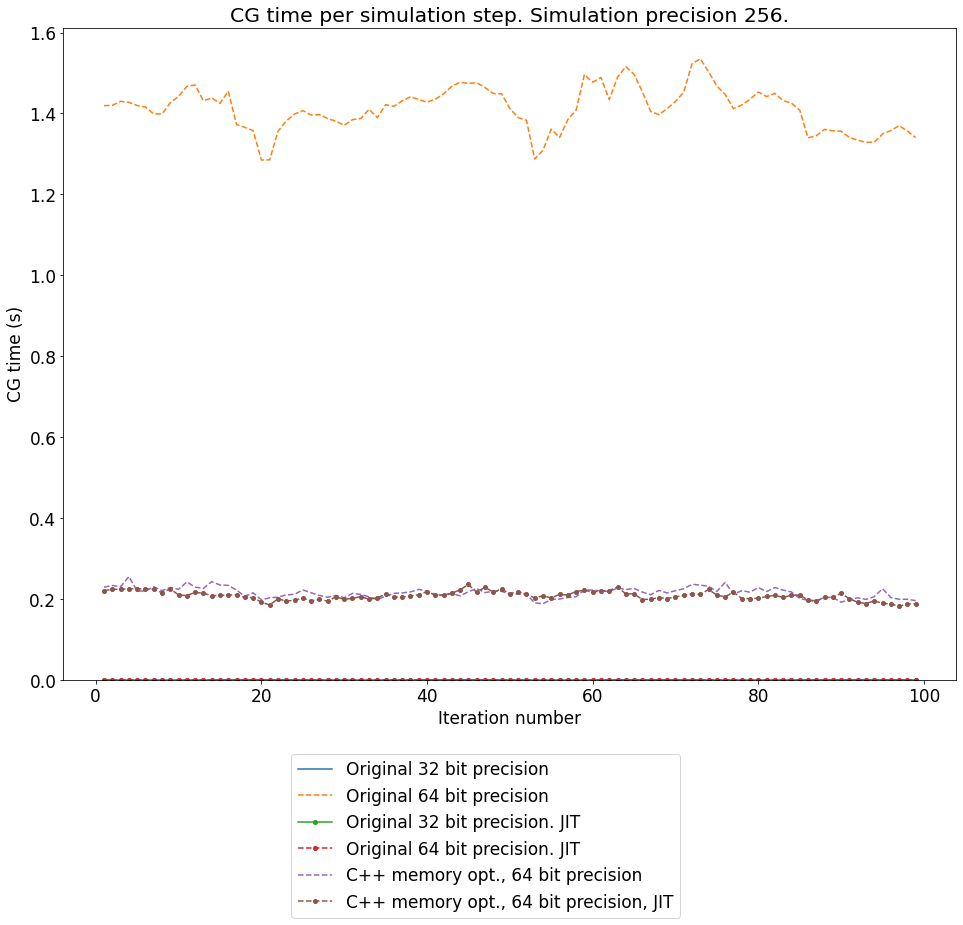

In [17]:

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(16,12), sharey=True)

# Non JIT on first column
ax.plot(measur_df.loc['ORIGINAL', 32,:,0, 256]['CG_TIME'][1:], label='Original 32 bit precision')
ax.plot(measur_df.loc['ORIGINAL', 64,:,0, 256]['CG_TIME'][1:], label='Original 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['ORIGINAL', 32,:,1, 256]['CG_TIME'][1:], label='Original 32 bit precision. JIT', marker='o', markersize=4)
ax.plot(measur_df.loc['ORIGINAL', 64,:,1, 256]['CG_TIME'][1:], label='Original 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['C++_opt', 64,:,0, 256]['CG_TIME'][1:], label='C++ memory opt., 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++_opt', 64,:,1, 256]['CG_TIME'][1:], label='C++ memory opt., 64 bit precision, JIT', linestyle='--', marker='o', markersize=4)
# center plot
# legend at bottom right
ax.legend(bbox_to_anchor=(0.7, -0.1), ncol=1)
ax.set_ylim(bottom=0) # Start y axis at 0
ax.set_xlabel('Iteration number')
ax.set_ylabel('CG time (s)')
ax.set_title('CG time per simulation step. Simulation precision 256.')

plt.savefig('figures/256sim/cg_time_per_simulation_step_256sim_precision.pdf', bbox_inches='tight')

# Step times plots

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(16,12), sharey=True)

# Non JIT on first column
ax.plot(measur_df.loc['ORIGINAL', 64,:,0, 64]['ITERATIONS'][1:], label='Original 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['ORIGINAL', 32,:,0, 64]['ITERATIONS'][1:], label='Original 32 bit precision')
ax.plot(measur_df.loc['MATMUL', 64,:,0, 64]['ITERATIONS'][1:], label='cuSPARSE Matmul 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['MATMUL', 32,:,0, 64]['ITERATIONS'][1:], label='cuSPARSE Matmul 32 bit precision')
ax.plot(measur_df.loc['C++', 64,:,0, 64]['ITERATIONS'][1:], label='C++ 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++', 64,:,1, 64]['ITERATIONS'][1:], label='C++ 64 bit precision, JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['C++_opt', 64,:,0, 64]['ITERATIONS'][1:], label='C++ memory opt., 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++_opt', 64,:,1, 64]['ITERATIONS'][1:], label='C++ memory opt., 64 bit precision, JIT', linestyle='--', marker='o', markersize=4)
ax.set_xlabel('Iteration number')
ax.set_ylabel('CG time (s)')
ax.set_title('CG iterations per step. Simulation precision 64.')
ax.legend()

plt.savefig('figures/64sim/cg_iterations_64sim_precision.pdf', bbox_inches='tight')

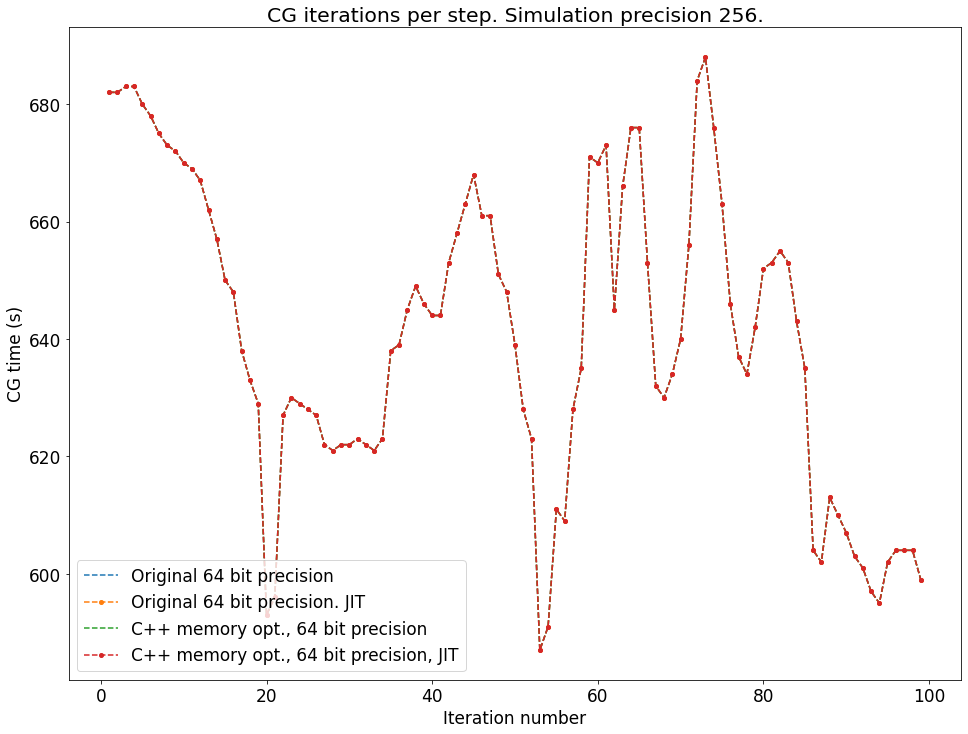

In [26]:
fig, ax = plt.subplots(figsize=(16,12), sharey=True)

# Non JIT on first column
#ax.plot(measur_df.loc['ORIGINAL', 32,:,0, 256]['ITERATIONS'][1:], label='Original 32 bit precision')
ax.plot(measur_df.loc['ORIGINAL', 64,:,0, 256]['ITERATIONS'][1:], label='Original 64 bit precision', linestyle='--')
#ax.plot(measur_df.loc['ORIGINAL', 32,:,1, 256]['ITERATIONS'][1:], label='Original 32 bit precision. JIT', marker='o', markersize=4)
ax.plot(measur_df.loc['ORIGINAL', 64,:,1, 256]['ITERATIONS'][1:], label='Original 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['C++_opt', 64,:,0, 256]['ITERATIONS'][1:], label='C++ memory opt., 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++_opt', 64,:,1, 256]['ITERATIONS'][1:], label='C++ memory opt., 64 bit precision, JIT', linestyle='--', marker='o', markersize=4)
ax.set_xlabel('Iteration number')
ax.set_ylabel('CG time (s)')
ax.set_title('CG iterations per step. Simulation precision 256.')
ax.legend()

plt.savefig('figures/256sim/cg_iterations_256sim_precision.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,10), sharey=True)

# Non JIT on first column
ax[0].plot(measur_df.loc['ORIGINAL', 64,:,0, 64]['TIME'][1:], label='Original 64 bit precision', linestyle='--')
ax[0].plot(measur_df.loc['ORIGINAL', 32,:,0, 64]['TIME'][1:], label='Original 32 bit precision')
ax[0].plot(measur_df.loc['MATMUL', 64,:,0, 64]['TIME'][1:], label='cuSPARSE Matmul 64 bit precision', linestyle='--')
ax[0].plot(measur_df.loc['MATMUL', 32,:,0, 64]['TIME'][1:], label='cuSPARSE Matmul 32 bit precision')
ax[0].plot(measur_df.loc['C++', 64,:,0, 64]['TIME'][1:], label='C++ 64 bit precision', linestyle='--')
ax[0].plot(measur_df.loc['C++_opt', 64,:,0, 64]['TIME'][1:], label='C++ memory opt., 64 bit precision', linestyle='--')
ax[0].legend()
ax[0].set_ylim(bottom=0) # Start y axis at 0
ax[0].set_xlabel('Iteration number')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Time per simulation step, Non JIT. Simulation precision 64.')
# Add horizontal grid lines. Dotted style. Faded grey color.
ax[0].grid(axis='y', linestyle='--', color='lightgrey')

ax[1].plot(measur_df.loc['ORIGINAL', 64,:,1, 64]['TIME'][2:], label='Original 64 bit precision', linestyle='--', marker='o', markersize=4)
ax[1].plot(measur_df.loc['ORIGINAL', 32,:,1, 64]['TIME'][2:], label='Original 32 bit precision', marker='o', markersize=4)
ax[1].plot(measur_df.loc['C++', 64,:,1, 64]['TIME'][2:], label='C++ 64 bit precision', linestyle='--', marker='o', markersize=4)
ax[1].plot(measur_df.loc['C++_opt', 64,:,1, 64]['TIME'][2:], label='C++ memory opt., 64 bit precision', linestyle='--', marker='o', markersize=4)
ax[1].legend()
ax[1].set_ylim(bottom=0) # Start y axis at 0
ax[1].set_xlabel('Iteration number')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('Time per simulation step, JIT. Simulation precision 64.')
# Add horizontal grid lines. Dotted style. Faded grey color.
ax[1].grid(axis='y', linestyle='--', color='lightgrey')

plt.savefig('figures/64sim/time_per_step_64sim_precision.pdf', bbox_inches='tight')


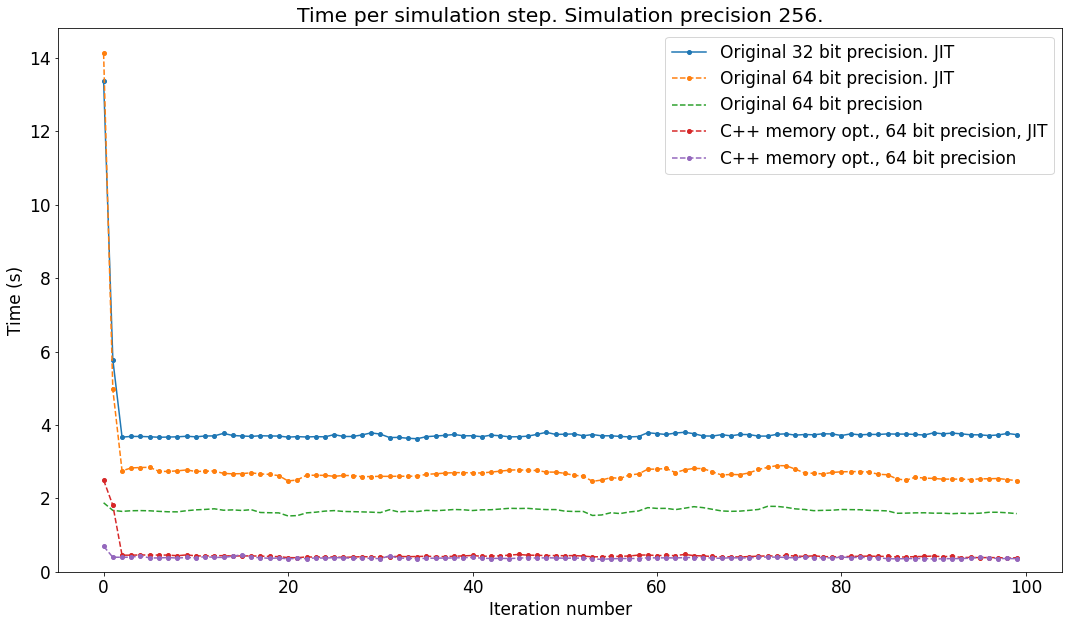

In [38]:
fig, ax = plt.subplots(figsize=(18,10))

# Non JIT on first column
ax.plot(measur_df.loc['ORIGINAL', 32,:,1, 256]['TIME'], label='Original 32 bit precision. JIT', marker='o', markersize=4)
ax.plot(measur_df.loc['ORIGINAL', 64,:,1, 256]['TIME'], label='Original 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['ORIGINAL', 64,:,0, 256]['TIME'], label='Original 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++_opt', 64,:,1, 256]['TIME'], label='C++ memory opt., 64 bit precision, JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['C++_opt', 64,:,0, 256]['TIME'], label='C++ memory opt., 64 bit precision', linestyle='--', marker='o', markersize=4)
ax.legend()
ax.set_ylim(bottom=0) # Start y axis at 0
ax.set_xlabel('Iteration number')
ax.set_ylabel('Time (s)')
ax.set_title('Time per simulation step. Simulation precision 256.')
plt.savefig('figures/256sim/time_per_step_256sim_precision.pdf', bbox_inches='tight')


# Init times

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))

ax.plot(measur_df.loc['ORIGINAL', 64,:,0, 64]['TIME'][:3], label='Original 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['ORIGINAL', 32,:,0, 64]['TIME'][:3], label='Original 32 bit precision')
ax.plot(measur_df.loc['MATMUL', 64,:,0, 64]['TIME'][:3], label='cuSPARSE Matmul 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['MATMUL', 32,:,0, 64]['TIME'][:3], label='cuSPARSE Matmul 32 bit precision')
ax.plot(measur_df.loc['C++', 64,:,0, 64]['TIME'][:3], label='C++ 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++_opt', 64,:,0, 64]['TIME'][:3], label='C++ memory opt., 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['ORIGINAL', 64,:,1, 64]['TIME'][:3], label='Original 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['ORIGINAL', 32,:,1, 64]['TIME'][:3], label='Original 32 bit precision. JIT', marker='o', markersize=4)
ax.plot(measur_df.loc['C++', 64,:,1, 64]['TIME'][:3], label='C++ 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['C++_opt', 64,:,1, 64]['TIME'][:3], label='C++ memory opt., 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.set_ylim(bottom=0) # Start y axis at 0
ax.set_xlabel('Iteration number')
ax.set_ylabel('Time (s)')
ax.set_title('Initialization times. Simulation precision 64.')
ax.legend()

plt.savefig('figures/64sim/initialization_times_64sim_precision.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))

ax.plot(measur_df.loc['ORIGINAL', 64,:,0, 256]['TIME'][:3], label='Original 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['ORIGINAL', 32,:,0, 256]['TIME'][:3], label='Original 32 bit precision')
ax.plot(measur_df.loc['MATMUL', 64,:,0, 256]['TIME'][:3], label='cuSPARSE Matmul 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['MATMUL', 32,:,0, 256]['TIME'][:3], label='cuSPARSE Matmul 32 bit precision')
ax.plot(measur_df.loc['C++', 64,:,0, 256]['TIME'][:3], label='C++ 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++_opt', 64,:,0, 256]['TIME'][:3], label='C++ memory opt., 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['ORIGINAL', 64,:,1, 256]['TIME'][:3], label='Original 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['ORIGINAL', 32,:,1, 256]['TIME'][:3], label='Original 32 bit precision. JIT', marker='o', markersize=4)
ax.plot(measur_df.loc['C++', 64,:,1, 256]['TIME'][:3], label='C++ 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['C++_opt', 64,:,1, 256]['TIME'][:3], label='C++ memory opt., 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.set_ylim(bottom=0) # Start y axis at 0
ax.set_xlabel('Iteration number')
ax.set_ylabel('Time (s)')
ax.set_title('Initialization times. Simulation precision 256.')
ax.legend()

plt.savefig('figures/256sim/initialization_times_256sim_precision.pdf', bbox_inches='tight')

Cummulative times

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
ax.set_xlabel('Simulation step')
ax.set_ylabel('Cumulative time (s)')
ax.set_title('Cumulative time per simulation step. Simulation precision 64.')

measur_df['CUM_TIME'] = measur_df.groupby(['IMPLEMENTATION', 'MATH_PRECISION', 'JIT', 'SIM_PRECISION'])['TIME'].cumsum()

ax.plot(measur_df.loc['ORIGINAL', 32,:,1, 256]['CUM_TIME'], label='Original 32 bit precision. JIT', marker='o', markersize=4)
ax.plot(measur_df.loc['ORIGINAL', 64,:,1, 256]['CUM_TIME'], label='Original 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['ORIGINAL', 64,:,0, 256]['CUM_TIME'], label='Original 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++_opt', 64,:,1, 256]['CUM_TIME'], label='C++ memory opt., 64 bit precision, JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['C++_opt', 64,:,0, 256]['CUM_TIME'], label='C++ memory opt., 64 bit precision', linestyle='--', marker='o', markersize=4)
ax.set_ylim(bottom=0) # Start y axis at 0
ax.legend()

plt.savefig('figures/64sim/time_per_simulation_step_64sim_precision.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
ax.set_xlabel('Simulation step')
ax.set_ylabel('Cumulative time (s)')
ax.set_title('Cumulative time per simulation step. Simulation precision 256.')

measur_df['CUM_TIME'] = measur_df.groupby(['IMPLEMENTATION', 'PRECISION', 'JIT'])['TIME'].cumsum()

ax.plot(measur_df.loc['ORIGINAL', 64,:,0, 256]['CUM_TIME'], label='Original 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['ORIGINAL', 32,:,0, 256]['CUM_TIME'], label='Original 32 bit precision')
ax.plot(measur_df.loc['MATMUL', 64,:,0, 256]['CUM_TIME'], label='cuSPARSE Matmul 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['MATMUL', 32,:,0, 256]['CUM_TIME'], label='cuSPARSE Matmul 32 bit precision')
ax.plot(measur_df.loc['C++', 64,:,0, 256]['CUM_TIME'], label='C++ 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['C++_opt', 64,:,0, 256]['CUM_TIME'], label='C++ memory opt., 64 bit precision', linestyle='--')
ax.plot(measur_df.loc['ORIGINAL', 64,:,1, 256]['CUM_TIME'], label='Original 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['ORIGINAL', 32,:,1, 256]['CUM_TIME'], label='Original 32 bit precision. JIT', marker='o', markersize=4)
ax.plot(measur_df.loc['C++', 64,:,1, 256]['CUM_TIME'], label='C++ 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.plot(measur_df.loc['C++_opt', 64,:,1, 256]['CUM_TIME'], label='C++ memory opt., 64 bit precision. JIT', linestyle='--', marker='o', markersize=4)
ax.set_ylim(bottom=0) # Start y axis at 0
ax.legend()

plt.savefig('figures/256sim/time_per_simulation_step_256sim_precision.pdf', bbox_inches='tight')

In [ ]:
# Average time

fig, ax = plt.subplots(figsize=(16,12))
ax.set_ylabel('Average time per step (s)')
ax.set_title('Average simulation step')

# Get only STEP 100 rows
measur_df_100 = measur_df.loc[:,:,99,:]
# Divide CUM_TIME by 100
measur_df_100['AVG_TIME'] = measur_df_100['CUM_TIME'] / 100
measur_df_100['COL_NAME'] = [', '.join(map(str,i)) for i in measur_df_100.index.tolist()]
measur_df_100['COL_NAME'] = measur_df_100['COL_NAME'].str.replace('64.0', '64 bit')
measur_df_100['COL_NAME'] = measur_df_100['COL_NAME'].str.replace('32.0', '32 bit')
measur_df_100['COL_NAME'] = measur_df_100['COL_NAME'].str.replace('0', 'no-JIT')
measur_df_100['COL_NAME'] = measur_df_100['COL_NAME'].str.replace('1', 'JIT')
measur_df_100['COL_NAME'] = measur_df_100['COL_NAME'].str.replace('_', ' ')
measur_df_100['COL_NAME'] = measur_df_100['COL_NAME'].str.replace('MATMUL', 'cuSPARSE Matmul')
measur_df_100['COL_NAME'] = measur_df_100['COL_NAME'].str.replace('opt', 'memory opt.')
measur_df_100['COL_NAME'] = measur_df_100['COL_NAME'].str.replace('ORIGINAL', 'Original')

# Sort by average AVG_TIME
measur_df_100 = measur_df_100.sort_values(by='AVG_TIME')
# Add color to each bar
# Plot, add color to each bar
ax.bar(measur_df_100['COL_NAME'], measur_df_100['AVG_TIME'], color='#1f77b4', label='Average time', width=0.5, align='center', alpha=0.5, edgecolor='black')
# Tilt x axis labels
ax.set_xticklabels(measur_df_100['COL_NAME'], rotation=25, ha='right')


# Add labels on top of bars
for i, v in enumerate(measur_df_100['AVG_TIME']):
    ax.text(i - 0.1, v + 0.005, str(round(v,3)), color='black')

# Save to file
plt.savefig('figures/average_time_per_simulation_step.pdf', bbox_inches='tight')

In [ ]:
# Divide all by ORIGINAL,32,JIT
measur_df_100['AVG_TIME'] = measur_df_100.loc['ORIGINAL', 32, 1]['AVG_TIME'] / measur_df_100['AVG_TIME']

# Plot
fig, ax = plt.subplots(figsize=(16,12))
ax.set_ylabel('Speed up factor')
ax.set_title('Speed up factor comparing to: Original, 32-bit precision, JIT')
ax.bar(measur_df_100['COL_NAME'], measur_df_100['AVG_TIME'], color='#1f77b4', label='Average time', width=0.5, align='center', alpha=0.5, edgecolor='black')
ax.set_xticklabels(measur_df_100['COL_NAME'], rotation=25, ha='right')
# Rename 

# Add labels on top of bars
for i, v in enumerate(measur_df_100['AVG_TIME']):
    ax.text(i - 0.1, v + 0.005, str(round(v,3)), color='black')

# Save to file
plt.savefig('figures/speed_up.pdf', bbox_inches='tight')